# Diffusion model example

Note: This notebook is designed to run with CPU (no GPU) runtime.

Import modules and set random seeds.

In [1]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from sklearn import datasets

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Generate the "Moons" dataset.

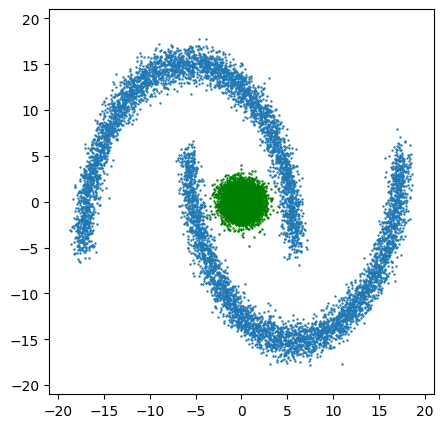

In [2]:
data = datasets.make_moons(8000, noise=0.05)[0].astype('float32')
norm = layers.Normalization()
norm.adapt(data)
train_data = norm(data) * 10
normal_samples = np.random.multivariate_normal(
    [0, 0], [[1, 0], [0, 1]], size=8000)

fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-21, 21))
subplot.set_ylim((-21, 21))
subplot.set_aspect('equal')
_ = subplot.scatter(train_data[:, 0], train_data[:, 1], s=0.5)
_ = subplot.scatter(normal_samples[:, 0], normal_samples[:, 1],
                color='green', s=0.5)

Define a function for the diffusion schedule using the offset cosine schedule.

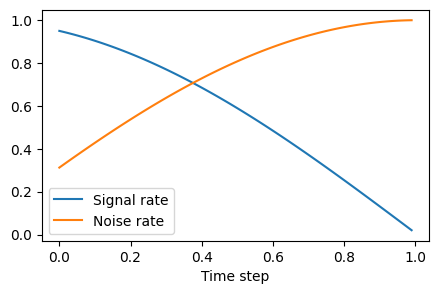

In [3]:
def diffusion_schedule(diffusion_times):
    # offset cosine schedule
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)
    return noise_rates, signal_rates


times = np.linspace(0, 1, 100)
df = DataFrame({'Signal rate': diffusion_schedule(times)[1],
                'Noise rate': diffusion_schedule(times)[0]})
df.index.name = 'Time step'
ax = df.plot(figsize=(5, 3))
xticks = np.array([0, 20, 40, 60, 80, 100])
ax.set_xticks(xticks)
_ = ax.set_xticklabels(xticks/100)

Define a function to create an animation frame.

In [4]:
import matplotlib.animation as animation
from IPython.display import Image

def show_data(subplot, data):
    subplot.set_xlim((-21, 21))
    subplot.set_ylim((-21, 21))
    subplot.set_aspect('equal')
    a = subplot.scatter(data[:, 0], data[:, 1], color='#1f77b4', s=1)
    return [a]

Show the diffusion process.

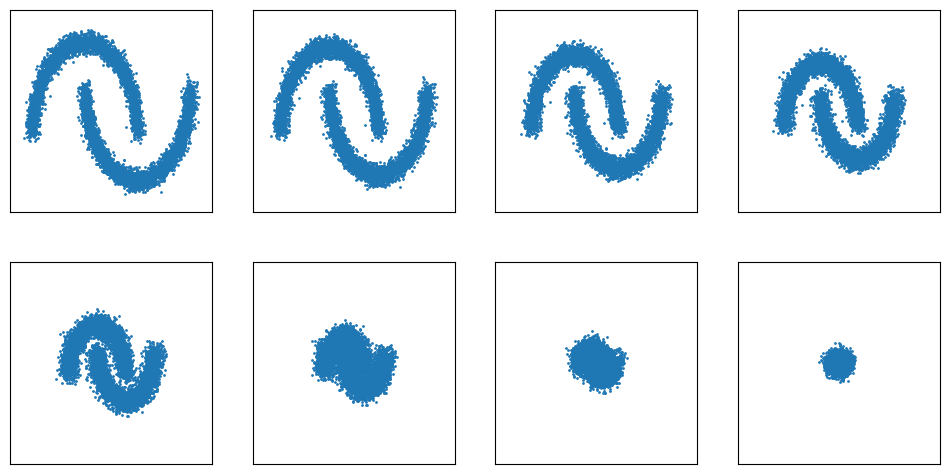

In [5]:
noise_data = np.random.multivariate_normal(
    [0, 0], [[1, 0], [0, 1]], size=len(train_data))

fig = plt.figure(figsize=(12, 6))
for c, t in enumerate(np.linspace(0, 1, 8)):
    subplot = fig.add_subplot(2, 4, c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    noise_rate, signal_rate = diffusion_schedule(t)
    diffused_data = signal_rate * train_data + noise_rate * noise_data
    show_data(subplot, diffused_data)

Show the diffusion process with an animation.

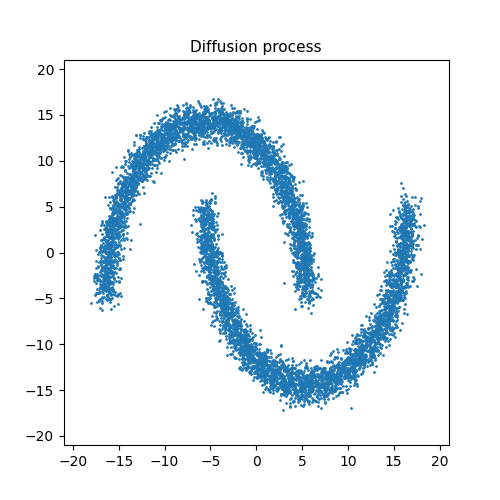

In [6]:
fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_title('Diffusion process', fontsize=11)
frames = []
for c, t in enumerate(np.linspace(0, 1, 20)):
    noise_rate, signal_rate = diffusion_schedule(t)
    diffused_data = signal_rate * train_data + noise_rate * noise_data
    frames.append(show_data(subplot, diffused_data))

ani = animation.ArtistAnimation(fig, frames, interval=80)
ani.save('diffusion_process.gif', writer='pillow')
plt.close()

Image('diffusion_process.gif')

Define the diffusion model.

In [7]:
diffusion_model = models.Sequential(name='diffusion_model')
diffusion_model.add(layers.Input(shape=(3,), name='input'))
diffusion_model.add(layers.Dense(64, name='expand'))
diffusion_model.add(layers.Dense(64, activation='relu', name='feedforward1'))
diffusion_model.add(layers.Dense(64, activation='relu', name='feedforward2'))
diffusion_model.add(layers.Dense(64, activation='relu', name='feedforward3'))
diffusion_model.add(layers.Dense(64, activation='relu', name='feedforward4'))
diffusion_model.add(layers.Dense(2, name='estimated_noise'))

diffusion_model.summary()

Model: "diffusion_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expand (Dense)                       │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward1 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward2 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward3 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward4 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ estimated_noise (Dense)              │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,026 (66.51 KB)

 Trainable params: 17,026 (66.51 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the mean square error as a loss function.

In [8]:
diffusion_model.compile(optimizer='adam', loss='mse')

Prepare training data.

In [9]:
num_examples = len(train_data)
inputs, labels = [], []
for _ in range(32):
    noise_data = np.random.multivariate_normal(
        [0, 0], [[1, 0], [0, 1]], size=num_examples)

    for _ in range(16): # select 16 random time steps
        t = np.random.uniform(0, 1, size=1)
        noise_rate, signal_rate = diffusion_schedule(t)
        noisy_data = signal_rate * train_data + noise_rate * noise_data
        noise_rate_stack = np.vstack(np.array([noise_rate]*num_examples))
        inputs.append(np.hstack((noisy_data, noise_rate_stack)))
        labels.append(noise_data) # predict noise_data

inputs, labels = np.vstack(inputs), np.vstack(labels)

Train the model.

In [10]:
%%time
history = diffusion_model.fit(inputs, labels,
                              batch_size=256, epochs=8, shuffle=True)

Epoch 1/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 0.7627
Epoch 2/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.6788
Epoch 3/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.6748
Epoch 4/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 0.6728
Epoch 5/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.6714
Epoch 6/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - loss: 0.6703
Epoch 7/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.6695
Epoch 8/8
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.6689
CPU times: user 9min 15s, sys: 20.8 s, total: 9min 35s
Wall time: 9min 3s


Define a function for the reverse diffusion process.

In [11]:
def reverse_diffusion(initial_data, steps):
    denoise_history = [initial_data]
    num_examples = len(initial_data)
    step_size = 1 / steps
    noisy_data = initial_data
    for step in range(steps):
        # Estimate noise_data from the current noisy_data
        t = 1 - step * step_size
        noise_rate, signal_rate = diffusion_schedule(t)
        noise_rate_stack = np.vstack(np.array([noise_rate]*num_examples))
        input_data = np.hstack((noisy_data, noise_rate_stack))
        noise_data = diffusion_model.predict(input_data, verbose=0)

        # Reconstruct the estimated original data
        estimated_original_data = (noisy_data - noise_rate * noise_data) / signal_rate

        # Get new noisy_data (1-step prior)
        next_noise_rate, next_signal_rate = diffusion_schedule(t-step_size)
        noisy_data = next_signal_rate * estimated_original_data + next_noise_rate * noise_data
        denoise_history.append(noisy_data)

    return denoise_history

Apply the reverse diffusion process to the normal distribution noise.

In [12]:
%%time
noise_data = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=8000)
denoise_history = reverse_diffusion(noise_data, steps=100)

CPU times: user 1min 4s, sys: 2.62 s, total: 1min 7s
Wall time: 1min 11s


Show the result of the reverse diffusion process.

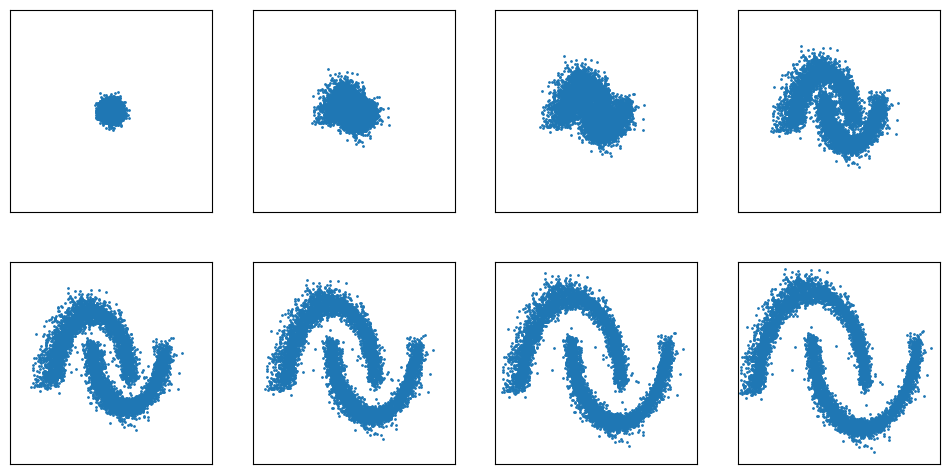

In [13]:
fig = plt.figure(figsize=(12, 6))
for c, i in enumerate(np.linspace(0, len(denoise_history)-1, 8)):
    subplot = fig.add_subplot(2, 4, c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    show_data(subplot, denoise_history[int(i)])

Show the result of the reverse diffusion process with an animation.

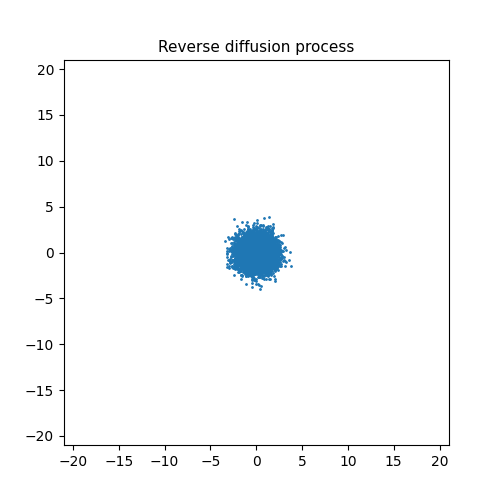

In [14]:
fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_title('Reverse diffusion process', fontsize=11)
frames = []
for c in range(0, len(denoise_history), 4):
    frames.append(show_data(subplot, denoise_history[c]))

ani = animation.ArtistAnimation(fig, frames, interval=80)
ani.save('reverse_diffusion_process.gif', writer='pillow')
plt.close()

Image('reverse_diffusion_process.gif')

Compare with the original data.

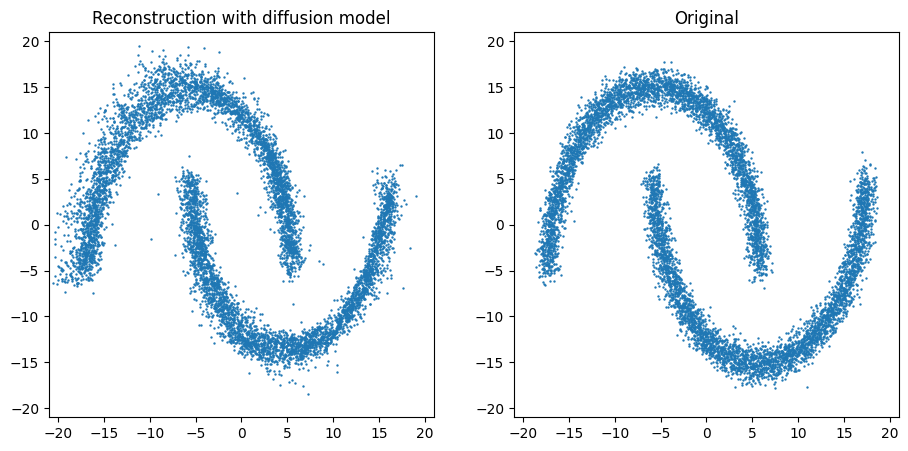

In [15]:
reconstruction = denoise_history[-1]

fig = plt.figure(figsize=(11, 5))
subplot = fig.add_subplot(1, 2, 1)
subplot.set_xlim((-21, 21))
subplot.set_ylim((-21, 21))
subplot.set_aspect('equal')
subplot.set_title('Reconstruction with diffusion model')
subplot.scatter(reconstruction[:, 0], reconstruction[:, 1], s=0.5)

subplot = fig.add_subplot(1, 2, 2)
subplot.set_xlim((-21, 21))
subplot.set_ylim((-21, 21))
subplot.set_aspect('equal')
subplot.set_title('Original')
_ = subplot.scatter(train_data[:, 0], train_data[:, 1], s=0.5)